In [1]:
%matplotlib inline
import numpy as np
import pdb
import sklearn.metrics.pairwise as distance
import matplotlib
#matplotlib.use('tkAgg')
import matplotlib.pyplot as plt
import glob
import sys
from matplotlib.ticker import MultipleLocator
import math
import pandas as pd
import time
from joblib import Parallel, delayed
import os
usable_cores = os.sched_getaffinity(0)

In [2]:
read = pd.read_csv('u.data', delim_whitespace=True, names=['user_id', 'movie_id', 'rating', 'time'])
read = read.sort_values('time').reset_index(drop=True)
read

,user_id,movie_id,rating,time
0,259,255,4,874724710
1,259,286,4,874724727
2,259,298,4,874724754
3,259,185,4,874724781
4,259,173,4,874724843
...,...,...,...,...
99995,729,689,4,893286638
99996,729,313,3,893286638
99997,729,328,3,893286638
99998,729,748,4,893286638


In [3]:
class Tables:
    def __init__(self, uid, vector):
        self.uid = uid
        self.vector = vector
class MADs:
    def __init__(self, k, value):
        self.k = k
        self.value = value

In [4]:
# first we use a 50%-50% train-test split
tau_row = read.loc[50000]
tau = tau_row.time
print(tau)

df_train = read[read['time'] <= tau]
df_test = read[read['time'] > tau]
# now construct the embedding table from training data
unique_id = df_train['user_id'].unique()
unique_movie = read['movie_id'].unique()

def table_loop(uid):
    vector = []
    for movie in unique_movie:
        check = df_train.loc[(df_train['user_id'] == uid) & (df_train['movie_id'] == movie)]
        if len(check) > 0:
            if check['rating'].iloc[0] >= 3:
                vector.append(1)
            else:
                vector.append(0)
        else:
            vector.append(0)
    vector = np.array(vector)
    result = Tables(uid, vector)
    return result

table = Parallel(n_jobs=len(usable_cores))(delayed(table_loop)(uid) for uid in unique_id)

882826944


In [5]:
table[0].__dict__

{'uid': 259, 'vector': array([1, 1, 1, ..., 0, 0, 0])}

In [6]:
# Now find top k similar users for each user in testing dataset
ks = [1, 5, 10, 15]
def predict_loop(uid, movie, score):
    # make sure test user is in train user list
    if uid in unique_id:
        usr_vector = [x for x in table if x.uid == uid][0].vector
        # rank all users in training set by similarity
        other_usrs = {}
        for train_uid in unique_id:
            # check if the training user has seen this movie
            check = df_train.loc[(df_train['user_id'] == train_uid) & (df_train['movie_id'] == movie)]
            if train_uid != uid and len(check) > 0:
                train_uid_vector = [x for x in table if x.uid == train_uid][0].vector
                other_usrs[train_uid] = np.dot(usr_vector,train_uid_vector)
        if len(other_usrs) == 0:
            # no user in training set has seen this movie, skip
            return
        other_usrs = dict(sorted(other_usrs.items(), key=lambda item: item[1], reverse=True))
        similar_usrs = list(other_usrs.keys())#[:ks[-1]]
        other_scores = []
        for similar_usr in similar_usrs:
            rating = df_train.loc[(df_train['user_id'] == similar_usr) & 
                                  (df_train['movie_id'] == movie)]['rating'].iloc[0]
            other_scores.append(rating)
        result = []
        for k in ks:
            mad = MADs(k, abs(np.mean(other_scores[:k]) - score)) # predict the score to be mean of similar users
            result.append(mad)
        naive_mad = MADs('naive', abs(np.mean(other_scores) - score))
        result.append(naive_mad)
        print(f'done {uid}, {movie}')
        return result
    else:
        # user has no history, cannot recommend, skip user
        return

#for uid, movie, score in zip(df_test['user_id'], df_test['movie_id'], df_test['rating']):
predictions = Parallel(n_jobs=len(usable_cores))(delayed(predict_loop)(uid, movie, score) for uid, 
                movie, score in zip(df_test['user_id'], df_test['movie_id'], df_test['rating']))

In [7]:
valid_pred = [x for x in predictions if x is not None]
valid_pred[0][4].__dict__

{'k': 'naive', 'value': 0.48571428571428577}

In [8]:
all_mads = {}
ks = [1, 5, 10, 15, 'naive']
for k in ks:
    all_mads[k] = []
    k_ind = ks.index(k)
    for pred in valid_pred:
        all_mads[k].append(pred[k_ind].value)
    all_mads[k] = np.mean(all_mads[k])

In [9]:
# now implement the naive scheme
all_mads

{1: 0.9649591189721342,
 5: 0.879133989654597,
 10: 0.8586656654986373,
 15: 0.8488708354885562,
 'naive': 0.8579070105469588}

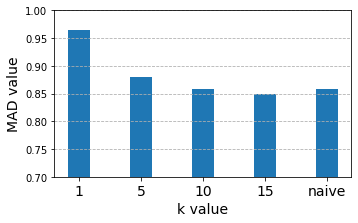

In [10]:
fig, axs = plt.subplots(1, 1, gridspec_kw={'hspace': 0.1, 'wspace': 0.2, 'bottom': 0.13, 
                                           'top': 0.9, 'right':0.995, 'left':0.17}, figsize=(5,3))
x = np.arange(len(ks))
axs.bar(x, list(all_mads.values()), 0.35)
axs.set_ylabel('MAD value', fontsize=14)
axs.set_xticks(x)
axs.set_xticklabels(ks, fontsize=14)
axs.grid(which='major', axis='y', ls='dashed')
axs.set_ylim(0.7, 1)
axs.set_xlabel('k value', fontsize=14)
fig.savefig(f'plots/p6_2.png', bbox_inches='tight')